# Achievements effect on Retention to third month in ecosystem

We call 'Uncofoundedness' a scenario where a treatment is not randomly assigned to participants, so confounders effect on treatment assignment and outcome.

Treatment - purchase in one category.

We will test hypothesis:

$H_o$ - There is no difference in retention to third month between treatment and control groups.

$H_a$ - There is a difference in LTV between treatment and control groups.

In [1]:
from causalis.scenarios.unconfoundedness.dgp import generate_obs_hte_binary_26

data = generate_obs_hte_binary_26(return_causal_data=False, include_oracle=True)
data.head()


,y,d,tenure_months,avg_sessions_week,spend_last_month,age_years,prior_purchases_12m,support_tickets_90d,premium_user,mobile_user,weekend_user,email_opt_in,referred_user,m,m_obs,tau_link,g0,g1,cate
0,0.0,0.0,28.814654,1.0,78.459423,50.392490,4.0,2.0,0.0,1.0,1.0,1.0,0.0,0.136804,0.136804,-0.075690,0.259586,0.245305,-0.014281
1,1.0,1.0,10.987367,3.0,38.652698,31.652666,3.0,0.0,1.0,1.0,1.0,0.0,0.0,0.157599,0.157599,0.781429,0.592325,0.760425,0.168101
2,0.0,1.0,40.678212,9.0,98.950760,48.634055,4.0,5.0,0.0,1.0,0.0,0.0,0.0,0.165401,0.165401,0.209518,0.043862,0.053538,0.009676
3,0.0,1.0,14.331764,5.0,27.386588,42.502641,3.0,3.0,1.0,1.0,1.0,0.0,0.0,0.158897,0.158897,0.630457,0.148391,0.246602,0.098211
4,0.0,1.0,21.480304,2.0,119.753960,35.311382,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.169943,0.169943,0.346384,0.527043,0.611748,0.084704


In [4]:
from causalis.data_contracts import CausalData

causaldata = CausalData(df = data,
                        treatment='d',
                        outcome='y',
                        confounders=['tenure_months',
                                     'avg_sessions_week',
                                     'spend_last_month',
                                     'age_years',
                                     'prior_purchases_12m',
                                     'support_tickets_90d',
                                     'premium_user',
                                     'mobile_user',
                                     'weekend_user',
                                     'email_opt_in',
                                     'referred_user'])
causaldata

CausalData(df=(100000, 13), treatment='d', outcome='y', confounders=['tenure_months', 'avg_sessions_week', 'spend_last_month', 'age_years', 'prior_purchases_12m', 'support_tickets_90d', 'premium_user', 'mobile_user', 'weekend_user', 'email_opt_in', 'referred_user'])

In [5]:
from causalis.shared import outcome_stats
outcome_stats(causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,0.0,85067,0.437726,0.496110,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,1.0,14933,0.579388,0.493674,0.0,0.0,0.0,1.0,1.0,1.0,1.0


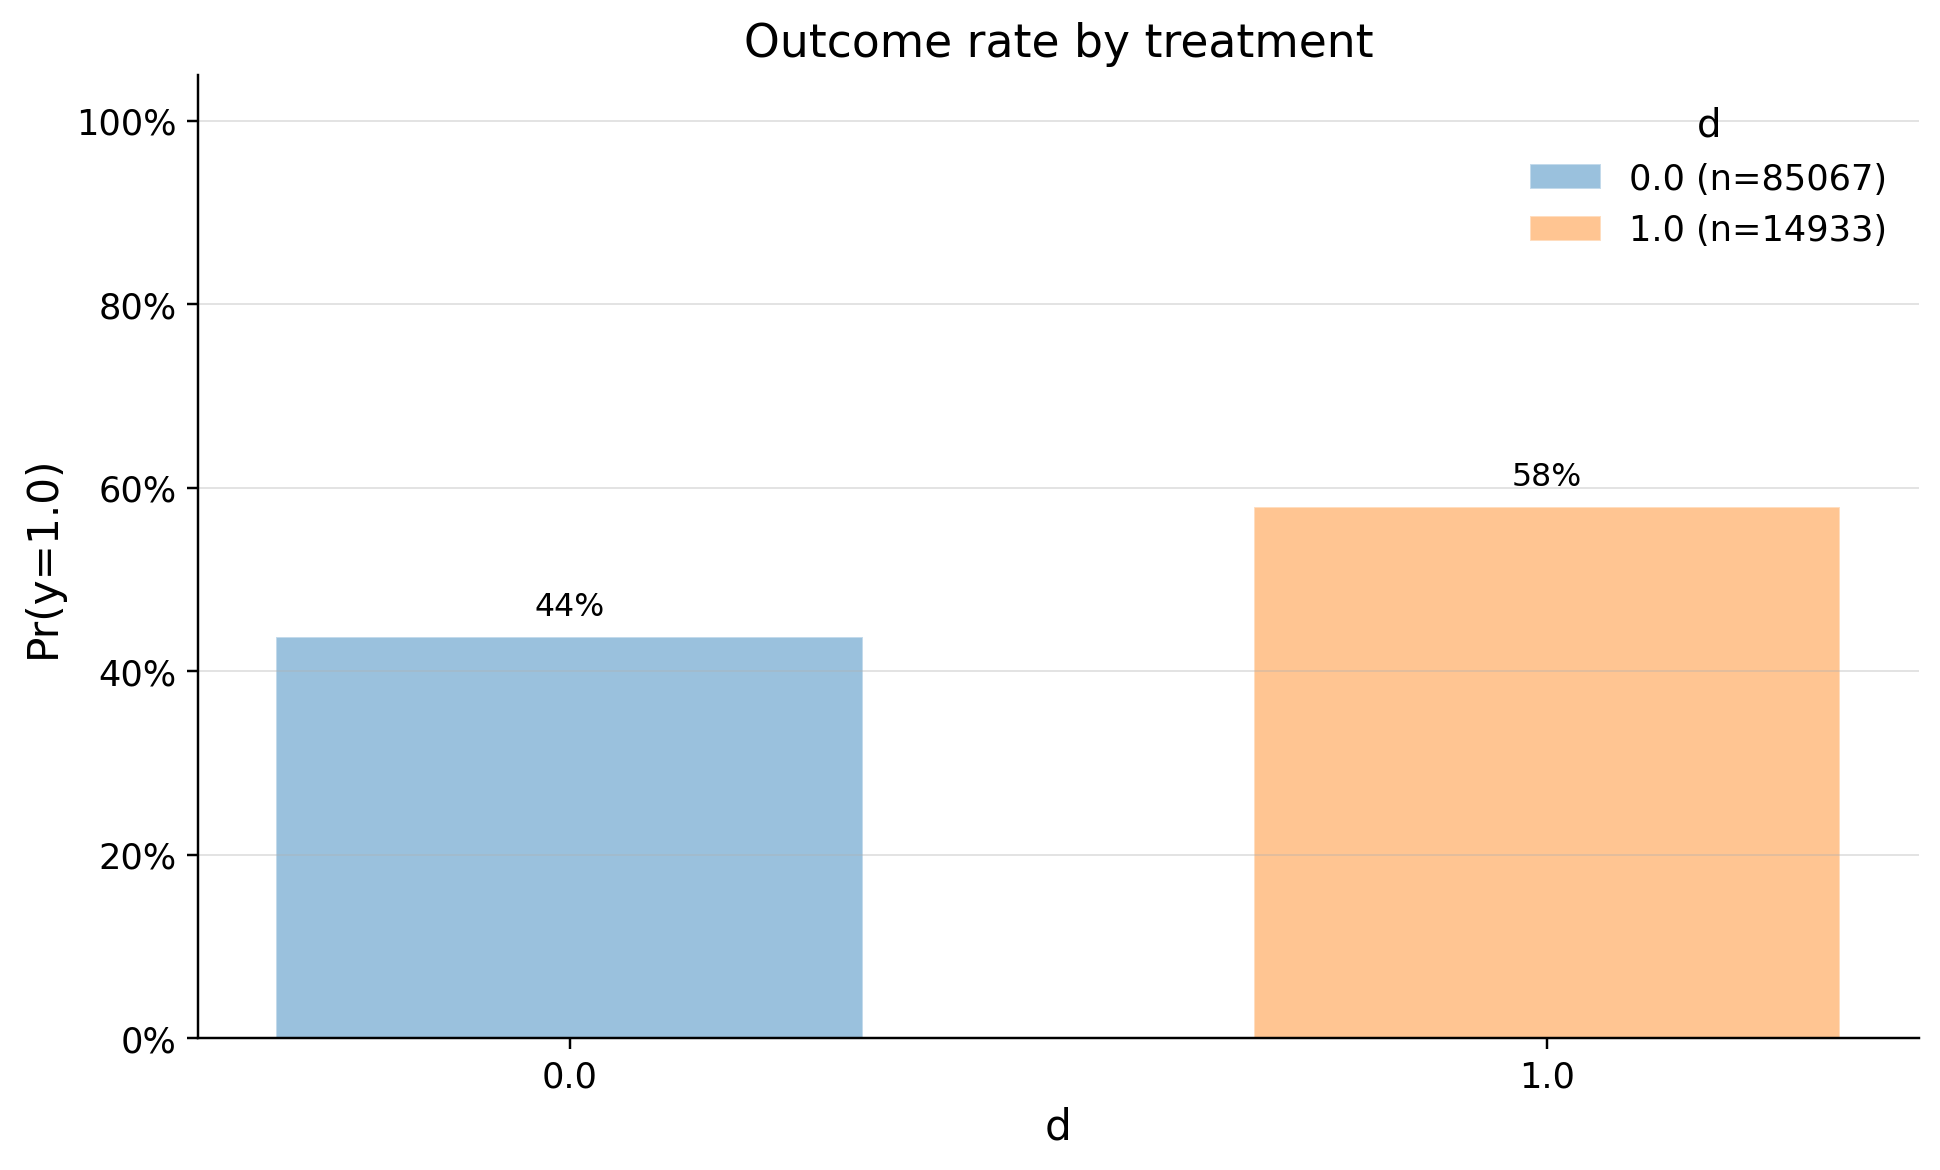

In [8]:
from causalis.shared.outcome_plots import outcome_plot_dist
outcome_plot_dist(causaldata)

In [7]:
from causalis.shared import confounders_balance

confounders_balance(causaldata)

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,spend_last_month,83.486832,114.093736,30.606905,0.336140,0.00000
1,premium_user,0.237378,0.371325,0.133948,0.294234,0.00000
2,avg_sessions_week,4.823410,6.005089,1.181680,0.271347,0.00000
3,prior_purchases_12m,3.420633,3.802317,0.381684,0.190848,0.00000
4,referred_user,0.243197,0.310052,0.066855,0.149870,0.00000
5,age_years,36.594622,35.069304,1.525318,-0.136350,0.00000
6,email_opt_in,0.542490,0.593652,0.051162,0.103421,0.00000
7,mobile_user,0.851270,0.882676,0.031406,0.092575,0.00000
8,support_tickets_90d,1.141982,1.243555,0.101572,0.091742,0.00000
9,tenure_months,28.338387,29.848652,1.510265,0.081531,0.00000


# Inference

In [11]:
from causalis.scenarios.unconfoundedness import IRM

model = IRM().fit(causaldata)

In [12]:
dml_result = model.estimate(score='ATTE')
dml_result.summary()

,value
field,
estimand,ATTE
model,IRM
value,"0.1026 (ci_abs: 0.0948, 0.1105)"
value_relative,"21.5248 (ci_rel: 19.7531, 23.2965)"
alpha,0.0500
p_value,0.0000
is_significant,True
n_treated,14933
n_control,85067


# Refutation

## Unconfoundedness

In [13]:
from causalis.scenarios.unconfoundedness.refutation.unconfoundedness.unconfoundedness_validation import run_unconfoundedness_diagnostics

rep_uc = run_unconfoundedness_diagnostics(causaldata ,dml_result)
rep_uc['summary']

,metric,value,flag
0,balance_max_smd,0.018197,GREEN
1,balance_frac_violations,0.000000,GREEN


### Sensitivity

In [14]:
from causalis.scenarios.unconfoundedness.refutation.unconfoundedness.sensitivity import (
    sensitivity_analysis, sensitivity_benchmark
)

In [15]:
sensitivity_benchmark(dml_result, benchmarking_set =['tenure_months'])

,r2_y,r2_d,rho,theta_long,theta_short,delta
d,7.802969e-07,0.012311,1.0,0.102623,0.10434,-0.001717


In [ ]:
sensitivity_analysis(dml_result, r2_y=0.000079, r2_d=0.048984, rho=1.0, alpha=0.05)

## SUTVA

In [16]:
from causalis.shared import print_sutva_questions
print_sutva_questions()

1.) Are your clients independent (i). Outcome of ones do not depend on others?
2.) Are all clients have full window to measure metrics?
3.) Do you measure confounders before treatment and outcome after?
4.) Do you have a consistent label of treatment, such as if a person does not receive a treatment, he has a label 0?


## Score

In [17]:
from causalis.scenarios.unconfoundedness.refutation.score.score_validation import run_score_diagnostics
rep_score = run_score_diagnostics(causaldata, dml_result)
rep_score["summary"]

,metric,value,flag
0,se_plugin,0.004015,NA
1,psi_p99_over_med,11.693513,YELLOW
2,psi_kurtosis,11.079355,YELLOW
3,max_|t|_g1,0.000000,GREEN
4,max_|t|_g0,1.562788,GREEN
5,max_|t|_m,1.063697,GREEN
6,oos_tstat_fold,0.000018,GREEN
7,oos_tstat_strict,0.000018,GREEN


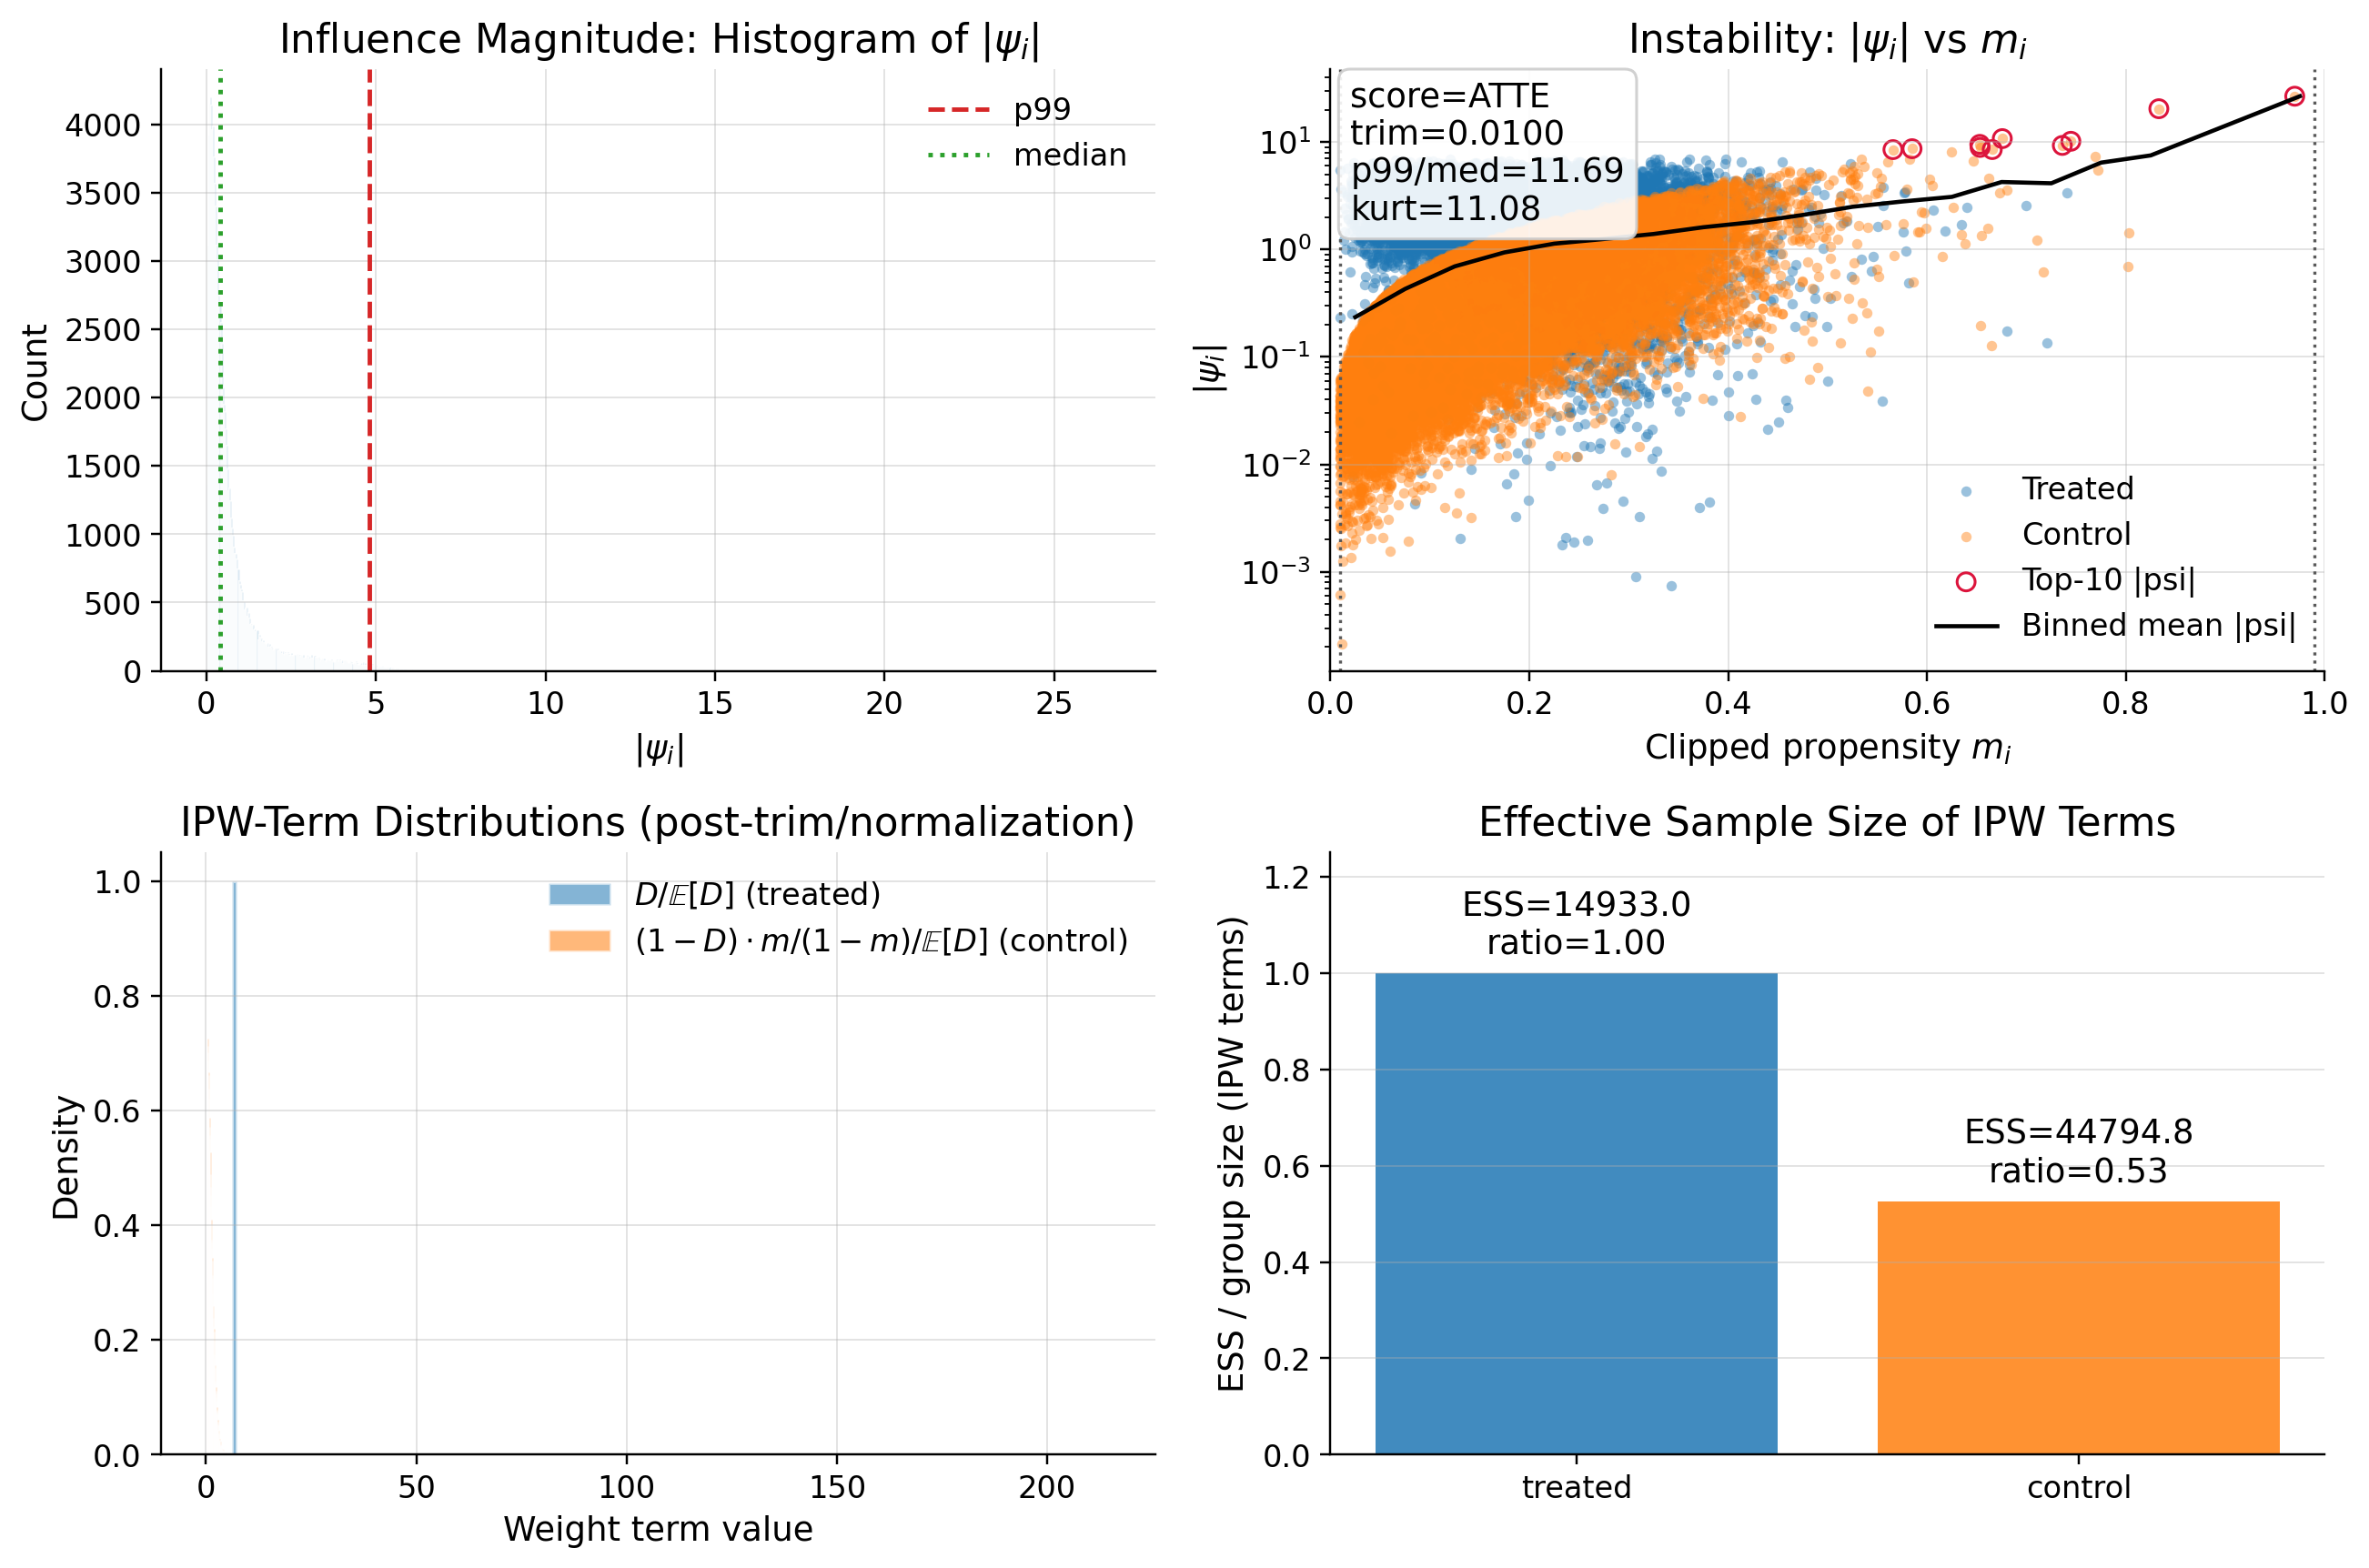

In [18]:
from causalis.scenarios.unconfoundedness.refutation import plot_influence_instability
plot_influence_instability(dml_result)

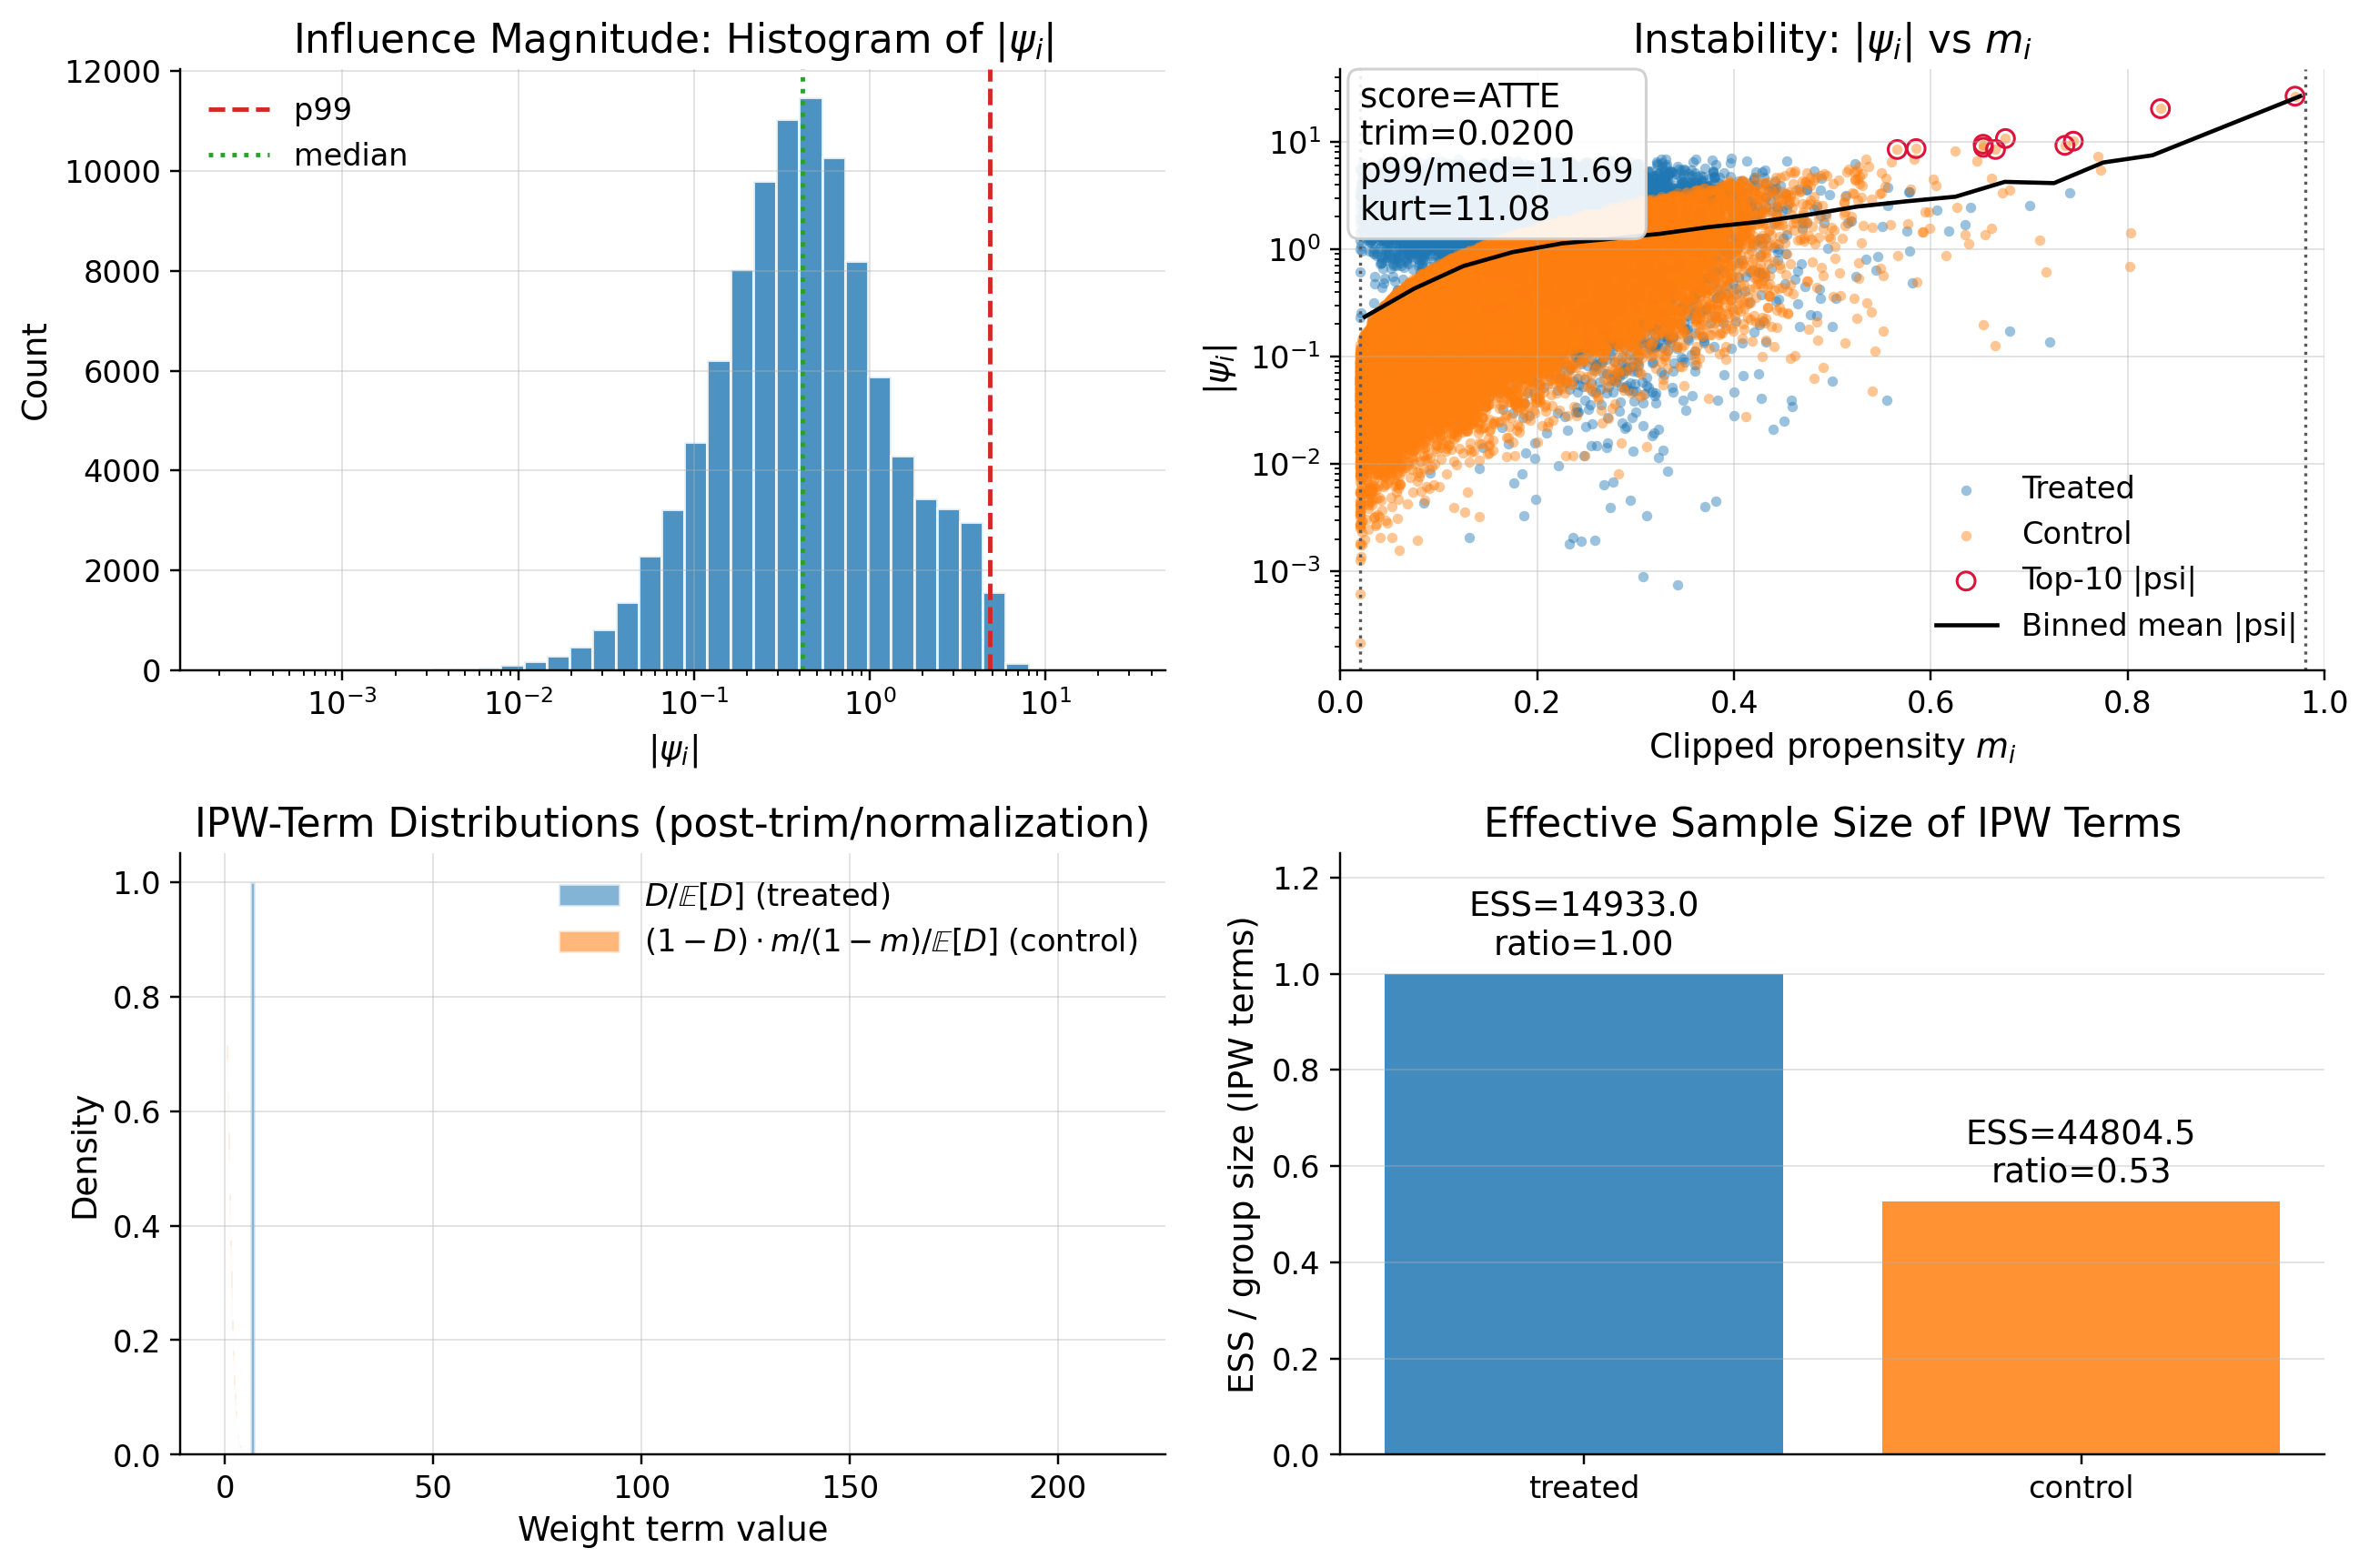

In [19]:
plot_influence_instability(dml_result, log_hist=True, trimming_threshold=0.02)

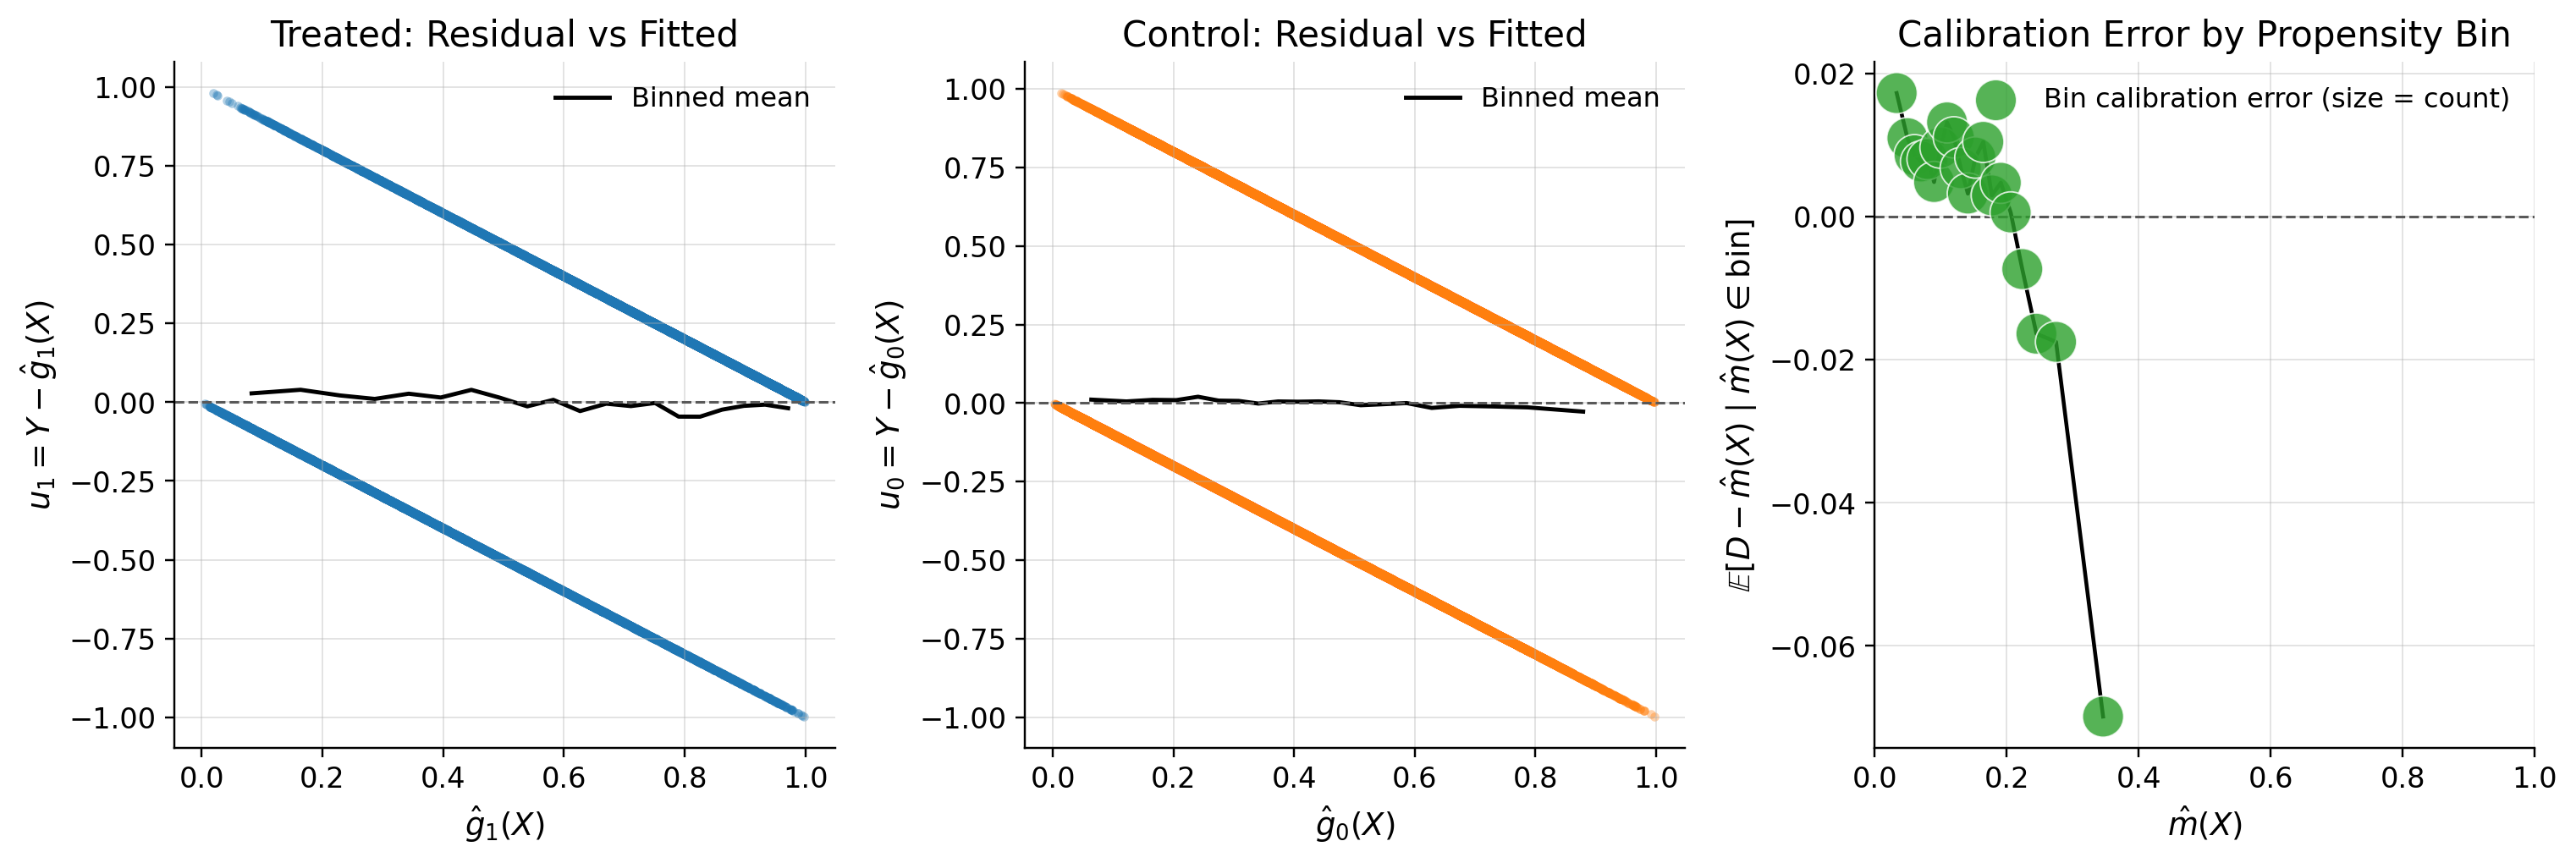

In [20]:
from causalis.scenarios.unconfoundedness.refutation import plot_residual_diagnostics
plot_residual_diagnostics(dml_result)

## Overlap

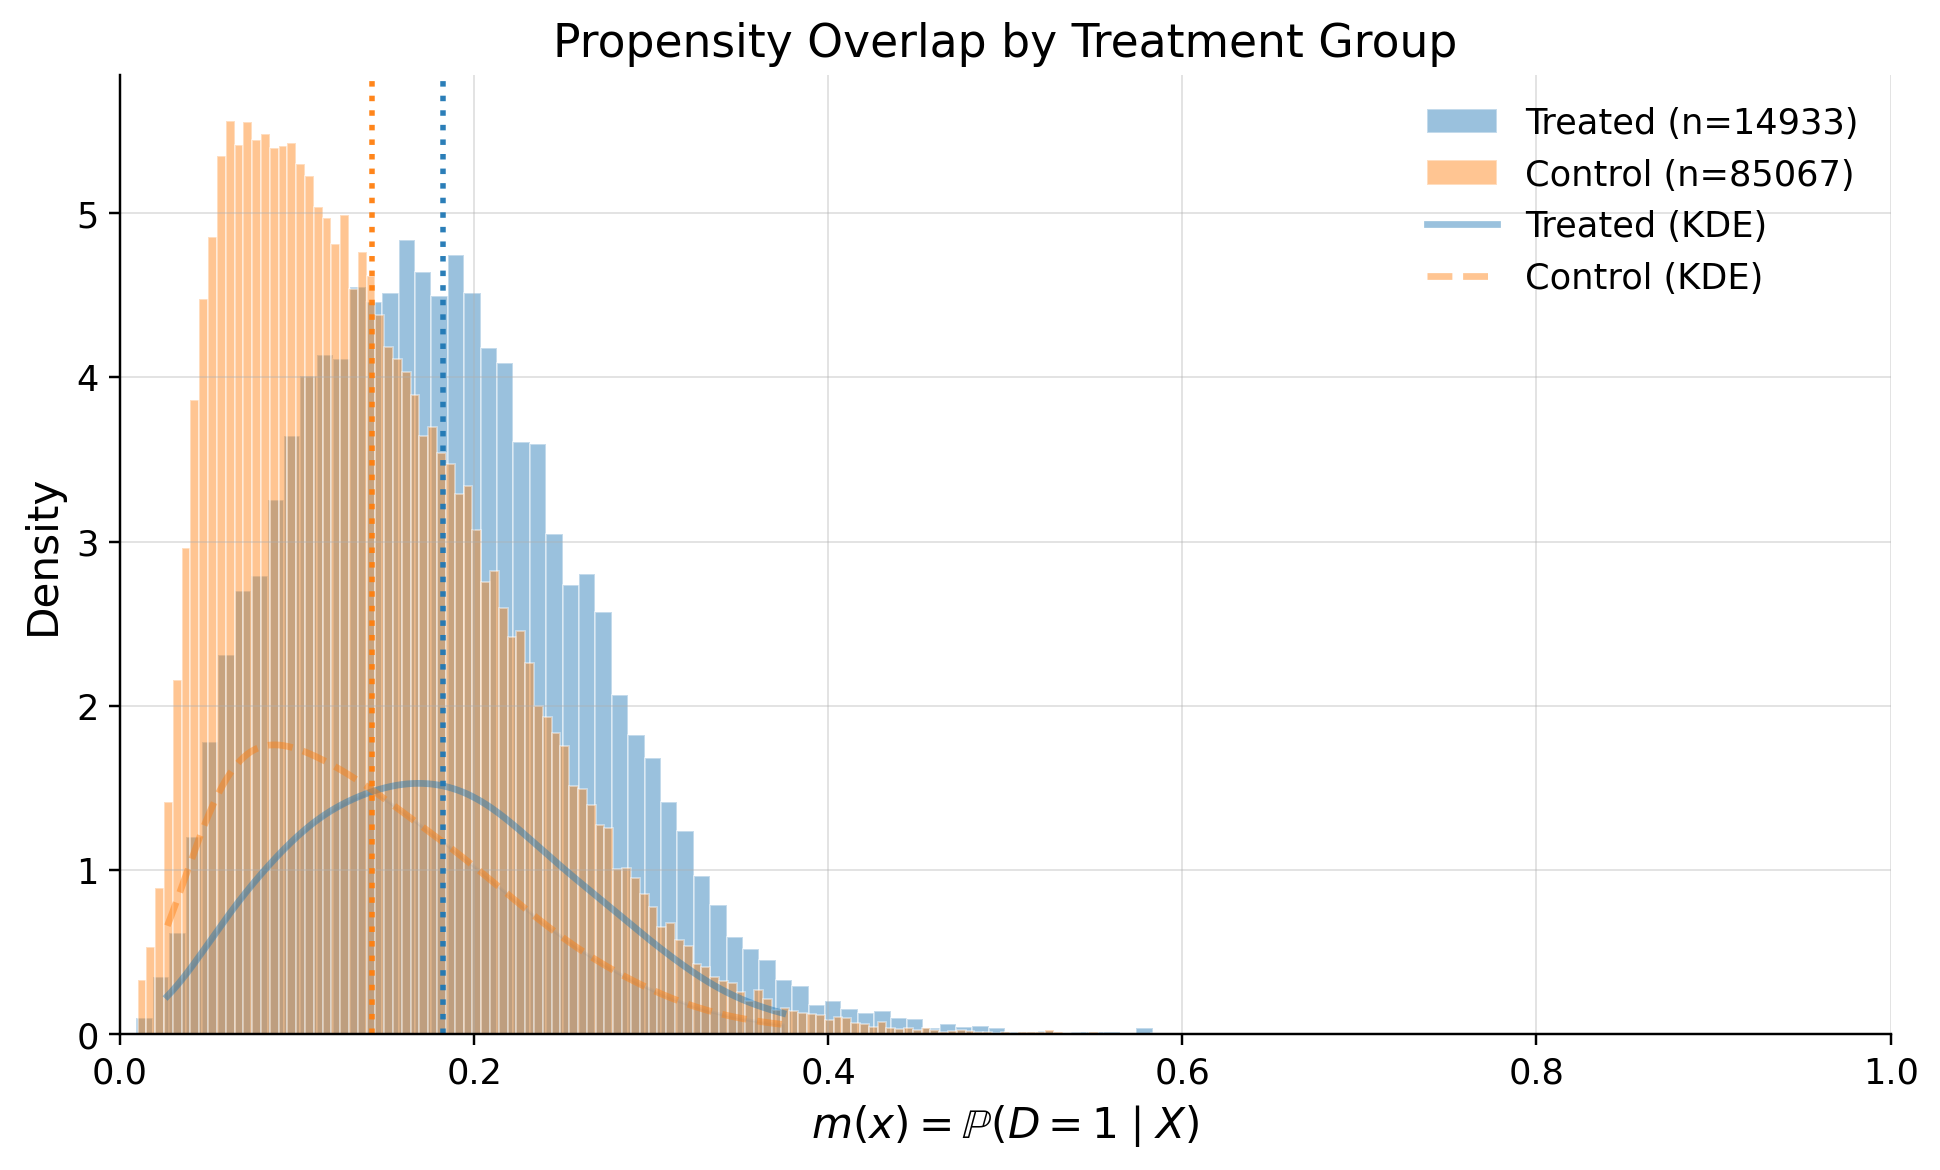

In [21]:
from causalis.scenarios.unconfoundedness.refutation import plot_m_overlap
plot_m_overlap(dml_result)

In [22]:
from causalis.scenarios.unconfoundedness.refutation import run_overlap_diagnostics
rep = run_overlap_diagnostics(causaldata, dml_result)
rep["summary"]

,metric,value,flag
0,edge_0.01_below,0.000530,GREEN
1,edge_0.01_above,0.000000,GREEN
2,edge_0.02_below,0.003840,GREEN
3,edge_0.02_above,0.000000,GREEN
4,KS,0.219189,GREEN
5,AUC,0.646729,GREEN
6,ESS_treated_ratio,0.649974,GREEN
7,ESS_control_ratio,0.979919,GREEN
8,tails_w1_q99/med,4.714865,YELLOW
9,tails_w0_q99/med,1.374649,YELLOW


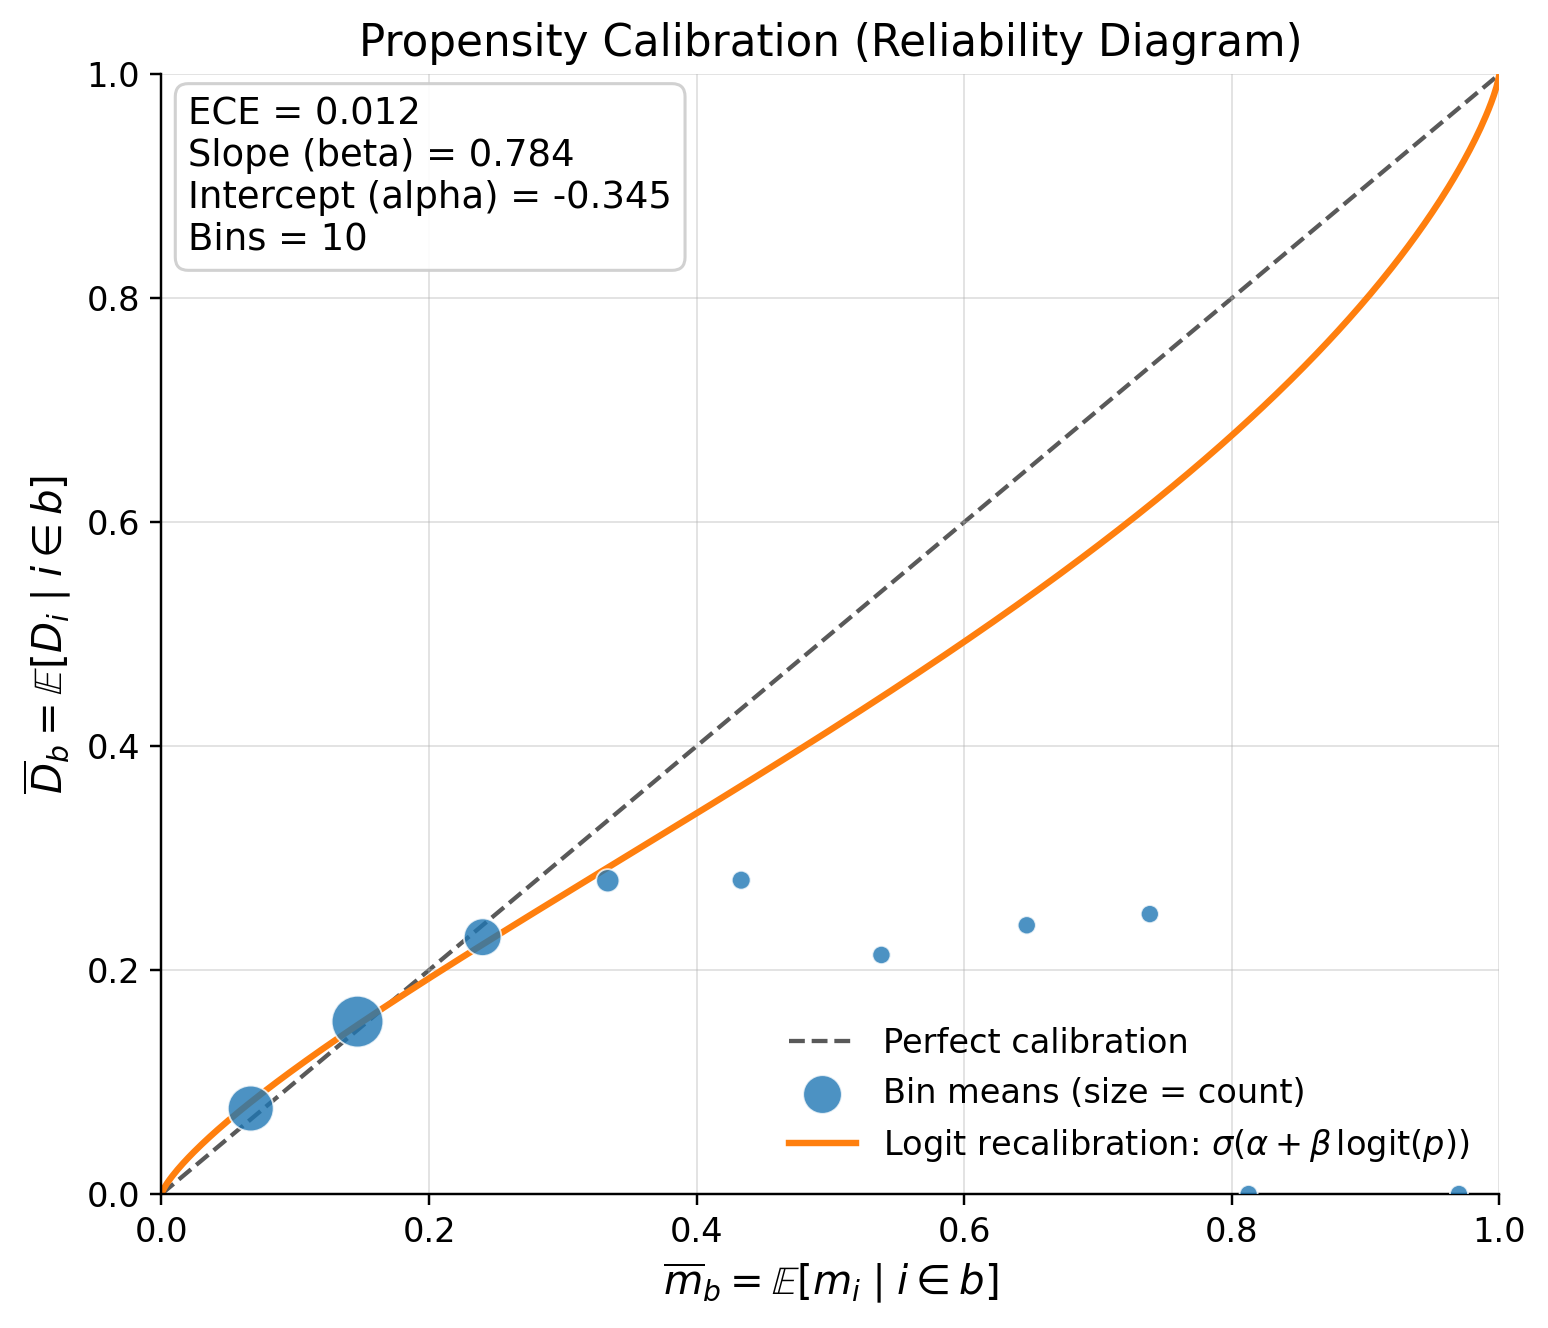

In [23]:
from causalis.scenarios.unconfoundedness.refutation import plot_propensity_reliability
plot_propensity_reliability(dml_result)

# Conclusion

First purchase in our product is retention 0.1026 (ci_abs: 0.0948, 0.1105) p.p. Model is specified correctly and there is no evidence that assumptions are false